In [196]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from torchvision import transforms
from torchvision.transforms import functional as F
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class DenoisingDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.image_paths = [os.path.join(root_dir, img) for img in os.listdir(root_dir)]
        self.transform = transform
    
    def add_noise(self, image):
        noise_level = np.random.uniform(0.05, 0.2)  # Niveaux de bruit aléatoires
        noisy_image = image + noise_level * torch.randn_like(image)
        return torch.clip(noisy_image, 0., 1.)
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        noisy_image = self.add_noise(image)
        return noisy_image, image

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

train_dataset = DenoisingDataset(root_dir='archive/images/train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)


In [160]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

class ContextGuidedBlock(nn.Module):
    def __init__(self, nIn, nOut, dilation_rate=2):
        super(ContextGuidedBlock, self).__init__()
        self.conv1x1 = nn.Conv2d(nIn, nOut // 2, kernel_size=1)
        self.conv3x3 = nn.Conv2d(nOut // 2, nOut, kernel_size=3, padding=dilation_rate, dilation=dilation_rate)
        self.bn = nn.BatchNorm2d(nOut)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.conv1x1(x)
        x = self.conv3x3(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

class CGNetDenoising(nn.Module):
    def __init__(self):
        super(CGNetDenoising, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        
        self.cg_block1 = ContextGuidedBlock(32, 32)
        self.cg_block2 = ContextGuidedBlock(32, 32)
        self.cg_block3 = ContextGuidedBlock(32, 32)
        
        self.conv2 = nn.Conv2d(32, 3, kernel_size=3, padding=1)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        
        x = self.cg_block1(x)
        x = self.cg_block2(x)
        x = self.cg_block3(x)
        
        x = self.conv2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CGNetDenoising().to(device)
print("Modèle corrigé initialisé.")


Modèle corrigé initialisé.


In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 15

# entrainement
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for noisy_imgs, clean_imgs in tqdm(train_loader):
        noisy_imgs = noisy_imgs.to(device)
        clean_imgs = clean_imgs.to(device)
        
        optimizer.zero_grad()
        outputs = model(noisy_imgs)
        
        loss = criterion(outputs, clean_imgs)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

torch.save(model.state_dict(), 'cgnet_denoising_optimized.pth')
print("Modèle sauvegardé.")


100%|██████████| 13/13 [00:18<00:00,  1.43s/it]


Epoch [1/15], Loss: 0.0070


100%|██████████| 13/13 [00:19<00:00,  1.48s/it]


Epoch [2/15], Loss: 0.0066


100%|██████████| 13/13 [01:19<00:00,  6.09s/it]


Epoch [3/15], Loss: 0.0059


100%|██████████| 13/13 [00:34<00:00,  2.66s/it]


Epoch [4/15], Loss: 0.0046


100%|██████████| 13/13 [00:17<00:00,  1.38s/it]


Epoch [5/15], Loss: 0.0044


100%|██████████| 13/13 [00:18<00:00,  1.39s/it]


Epoch [6/15], Loss: 0.0047


100%|██████████| 13/13 [00:17<00:00,  1.37s/it]


Epoch [7/15], Loss: 0.0054


100%|██████████| 13/13 [00:18<00:00,  1.39s/it]


Epoch [8/15], Loss: 0.0046


100%|██████████| 13/13 [00:18<00:00,  1.39s/it]


Epoch [9/15], Loss: 0.0048


100%|██████████| 13/13 [00:18<00:00,  1.40s/it]


Epoch [10/15], Loss: 0.0050


100%|██████████| 13/13 [00:18<00:00,  1.39s/it]


Epoch [11/15], Loss: 0.0056


100%|██████████| 13/13 [00:18<00:00,  1.39s/it]


Epoch [12/15], Loss: 0.0057


100%|██████████| 13/13 [00:17<00:00,  1.38s/it]


Epoch [13/15], Loss: 0.0054


100%|██████████| 13/13 [00:17<00:00,  1.37s/it]


Epoch [14/15], Loss: 0.0044


100%|██████████| 13/13 [00:17<00:00,  1.37s/it]

Epoch [15/15], Loss: 0.0045
Modèle sauvegardé.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.030005937..1.0032998].


PSNR Noisy: 20.10, PSNR Denoised: 28.11


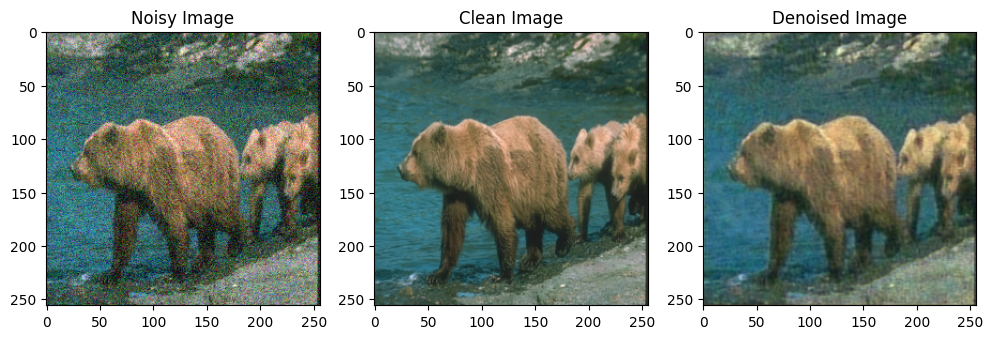

PSNR Noisy: 20.06, PSNR Denoised: 29.87


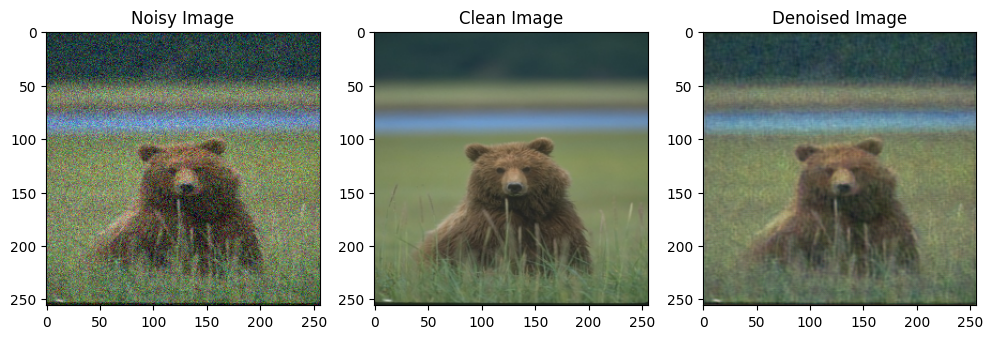

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.024609556..1.1619833].


PSNR Noisy: 20.56, PSNR Denoised: 23.70


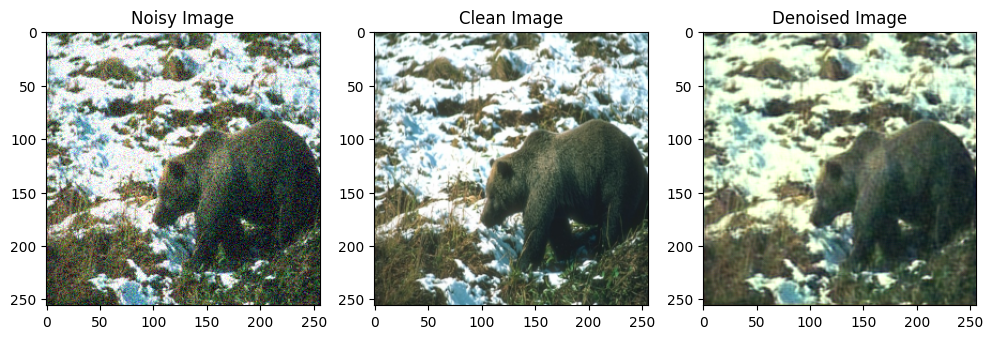

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.013637838..1.1252383].


PSNR Noisy: 20.12, PSNR Denoised: 28.70


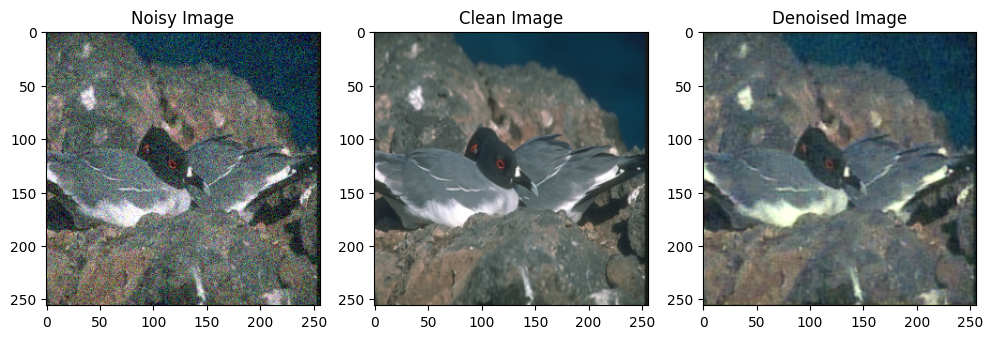

PSNR Noisy: 20.04, PSNR Denoised: 28.76


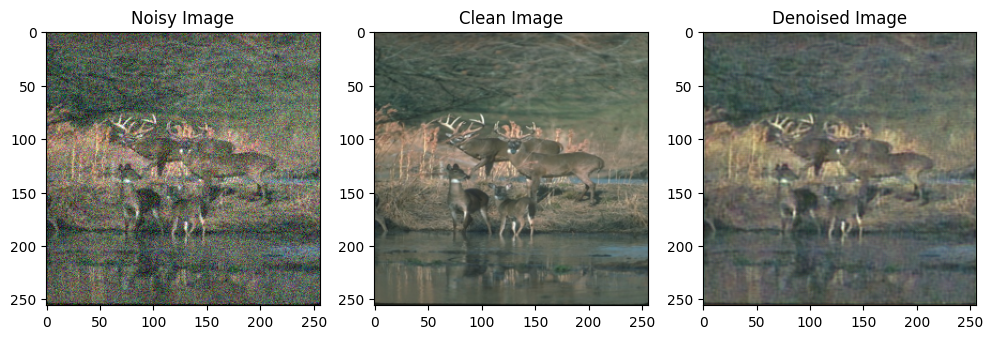

PSNR Noisy: 20.02, PSNR Denoised: 29.21


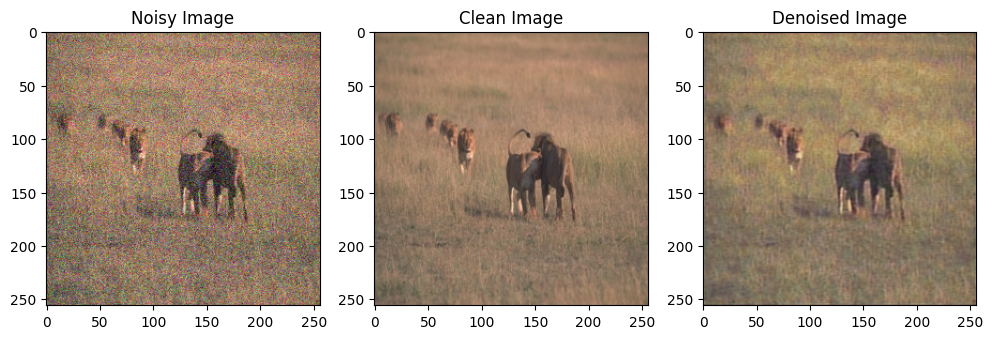

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.101906925..1.0042223].


PSNR Noisy: 20.01, PSNR Denoised: 30.24


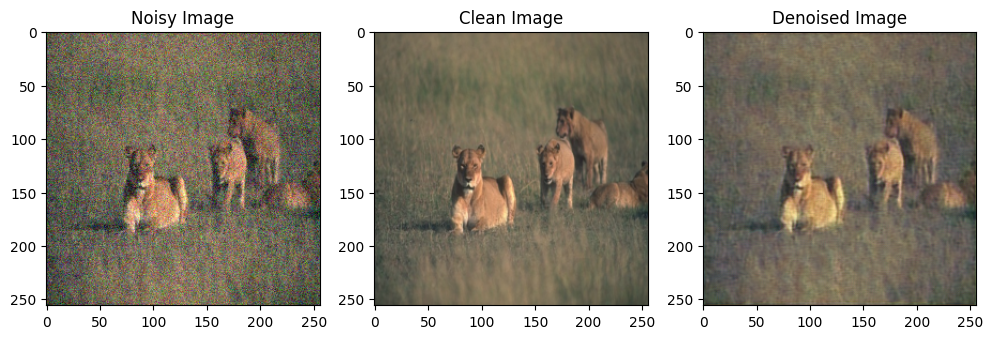

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.066557914..1.1364824].


PSNR Noisy: 20.13, PSNR Denoised: 26.88


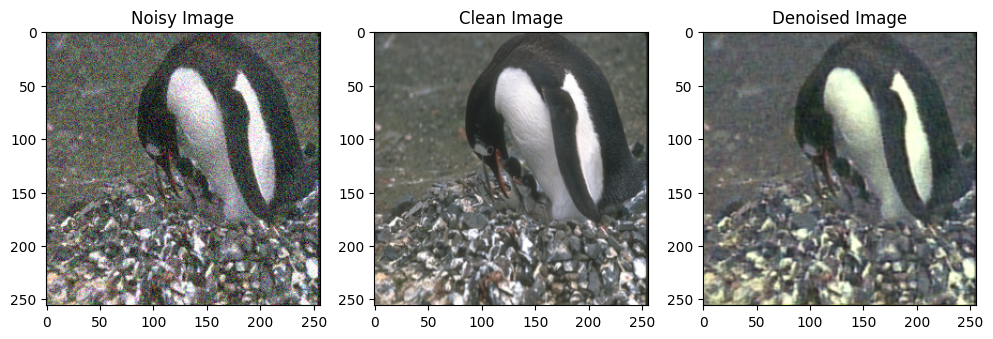

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.058564067..1.1425979].


PSNR Noisy: 20.25, PSNR Denoised: 29.46


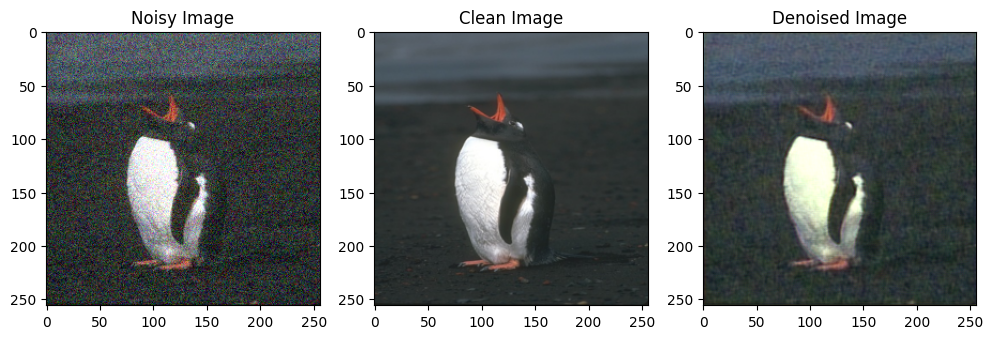

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.029301617..1.140051].


PSNR Noisy: 20.11, PSNR Denoised: 27.13


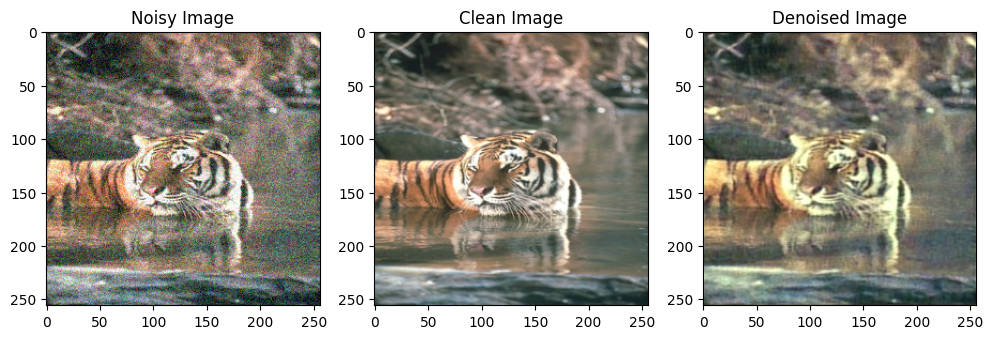

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.045876026..1.1051255].


PSNR Noisy: 20.16, PSNR Denoised: 24.71


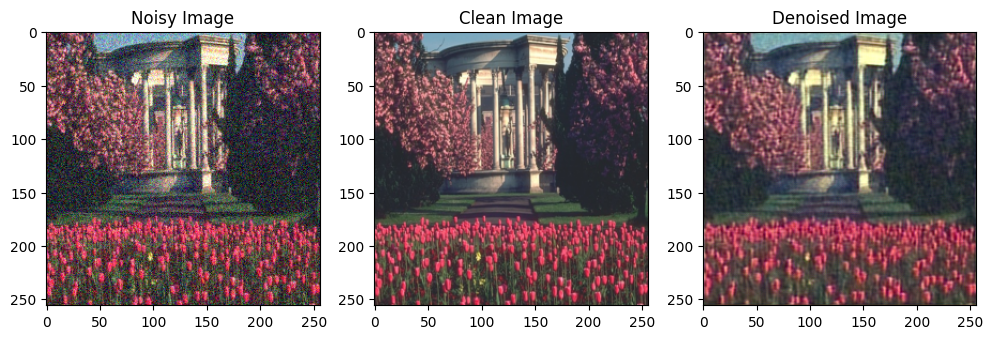

In [136]:
def show_sample(model, dataset, index):
    model.eval()
    noisy_img, clean_img = dataset[index]
    noisy_img = noisy_img.unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(noisy_img).cpu().squeeze()
    
    clean_img = clean_img.permute(1, 2, 0).numpy()
    noisy_img = noisy_img.squeeze().permute(1, 2, 0).cpu().numpy()
    output = output.permute(1, 2, 0).numpy()
    
    psnr_noisy = psnr(clean_img, noisy_img)
    psnr_denoised = psnr(clean_img, output)
    
    print(f"PSNR Noisy: {psnr_noisy:.2f}, PSNR Denoised: {psnr_denoised:.2f}")
    
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.title("Noisy Image")
    plt.imshow(noisy_img)
    
    plt.subplot(1, 3, 2)
    plt.title("Clean Image")
    plt.imshow(clean_img)
    
    plt.subplot(1, 3, 3)
    plt.title("Denoised Image")
    plt.imshow(output)
    plt.show()

# 10 premieres images
show_sample(model, train_dataset, 0)
show_sample(model, train_dataset, 1)
show_sample(model, train_dataset, 2)
show_sample(model, train_dataset, 3)
show_sample(model, train_dataset, 4)
show_sample(model, train_dataset, 5)
show_sample(model, train_dataset, 6)
show_sample(model, train_dataset, 7)
show_sample(model, train_dataset, 8)
show_sample(model, train_dataset, 9)
show_sample(model, train_dataset, 198)

